ACTIVIDAD 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importo librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import kstest
from scipy.stats import chisquare
from scipy.stats import chi2_contingency 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_hospital = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Horton/HortonGeneralHospital.csv')

In [3]:
df_hospital.head()

,Unnamed: 0,Cardio,Resp,Hypo,Adm,year,month
0,1,1,0,0,413,1999,11
1,2,1,0,0,443,1999,12
2,3,1,0,0,378,2000,1
3,4,0,0,0,385,2000,2
4,5,1,0,0,388,2000,3


In [4]:
# Elimino primera columna
df_hospital = df_hospital.drop('Unnamed: 0', axis=1)

In [5]:
# Creo variable 'ts' con la fecha y el mes. Actualizao índice
df_hospital['ts'] = df_hospital['year'].astype(str) + str('-') + df_hospital['month'].astype(str)
df_hospital['ts'] = pd.to_datetime(df_hospital['ts'], format = '%Y-%m')
df_hospital['date'] = df_hospital['ts']
df_hospital.set_index('ts', inplace=True)
df_hospital.head()

,Cardio,Resp,Hypo,Adm,year,month,date
ts,,,,,,,
1999-11-01,1,0,0,413,1999,11,1999-11-01
1999-12-01,1,0,0,443,1999,12,1999-12-01
2000-01-01,1,0,0,378,2000,1,2000-01-01
2000-02-01,0,0,0,385,2000,2,2000-02-01
2000-03-01,1,0,0,388,2000,3,2000-03-01


In [6]:
# Examino datos
df_hospital.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139 entries, 1999-11-01 to 2011-05-01
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Cardio  139 non-null    int64         
 1   Resp    139 non-null    int64         
 2   Hypo    139 non-null    int64         
 3   Adm     139 non-null    int64         
 4   year    139 non-null    int64         
 5   month   139 non-null    int64         
 6   date    139 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(6)
memory usage: 8.7 KB


In [7]:
# Examino datos
df_hospital.describe().T

,count,mean,std,min,25%,50%,75%,max
Cardio,139.0,0.863309,0.852970,0.0,0.0,1.0,1.0,3.0
Resp,139.0,0.251799,0.565859,0.0,0.0,0.0,0.0,4.0
Hypo,139.0,0.086331,0.281868,0.0,0.0,0.0,0.0,1.0
Adm,139.0,534.985612,73.129524,373.0,491.5,539.0,579.0,724.0
year,139.0,2005.129496,3.372597,1999.0,2002.0,2005.0,2008.0,2011.0
month,139.0,6.446043,3.503978,1.0,3.0,6.0,9.5,12.0


Crear nuevas variables con ratios de envio a UCI por admision:
Todos/Adm, Cardio/Adm, Resp/Adm, Hypo/Adm

In [8]:
# Añado nuevas características a la tabla
new_features = ['RatioCardio', 'RatioResp', 'RatioHypo']
old_features = ['Cardio', 'Resp', 'Hypo']
df_hospital[new_features] = df_hospital[old_features].apply(lambda x: x / (df_hospital['Adm'].values))

In [9]:
df_hospital.head()

,Cardio,Resp,Hypo,Adm,year,month,date,RatioCardio,RatioResp,RatioHypo
ts,,,,,,,,,,
1999-11-01,1,0,0,413,1999,11,1999-11-01,0.002421,0.0,0.0
1999-12-01,1,0,0,443,1999,12,1999-12-01,0.002257,0.0,0.0
2000-01-01,1,0,0,378,2000,1,2000-01-01,0.002646,0.0,0.0
2000-02-01,0,0,0,385,2000,2,2000-02-01,0.000000,0.0,0.0
2000-03-01,1,0,0,388,2000,3,2000-03-01,0.002577,0.0,0.0


In [10]:
# Calculo el ratio total
df_hospital['RatioTotal'] = df_hospital['RatioCardio'] + df_hospital['RatioResp'] + df_hospital['RatioHypo']

Creo intervalos para RatioTotal, (5 intervalos), Bajo 0, medio-bajo 1, medio 2, medio-alto 3 y alto *4*

In [11]:
# Creo nueva variable, dividiendo lo valores de los ratios en 5 intervalos, para mejor comprensión de los datos
df_hospital['RatioCut'] = pd.cut(df_hospital.RatioTotal,bins = 5, labels= False)
df_hospital.sort_values(by='RatioTotal', ascending=False)

,Cardio,Resp,Hypo,Adm,year,month,date,RatioCardio,RatioResp,RatioHypo,RatioTotal,RatioCut
ts,,,,,,,,,,,,
2004-02-01,3,2,1,553,2004,2,2004-02-01,0.005425,0.003617,0.001808,0.010850,4
2003-08-01,3,1,0,532,2003,8,2003-08-01,0.005639,0.001880,0.000000,0.007519,3
2002-12-01,2,1,1,532,2002,12,2002-12-01,0.003759,0.001880,0.001880,0.007519,3
2000-05-01,3,0,0,409,2000,5,2000-05-01,0.007335,0.000000,0.000000,0.007335,3
2008-11-01,3,1,0,550,2008,11,2008-11-01,0.005455,0.001818,0.000000,0.007273,3
...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-01,0,0,0,498,2008,6,2008-06-01,0.000000,0.000000,0.000000,0.000000,0
2003-01-01,0,0,0,509,2003,1,2003-01-01,0.000000,0.000000,0.000000,0.000000,0
2008-12-01,0,0,0,637,2008,12,2008-12-01,0.000000,0.000000,0.000000,0.000000,0


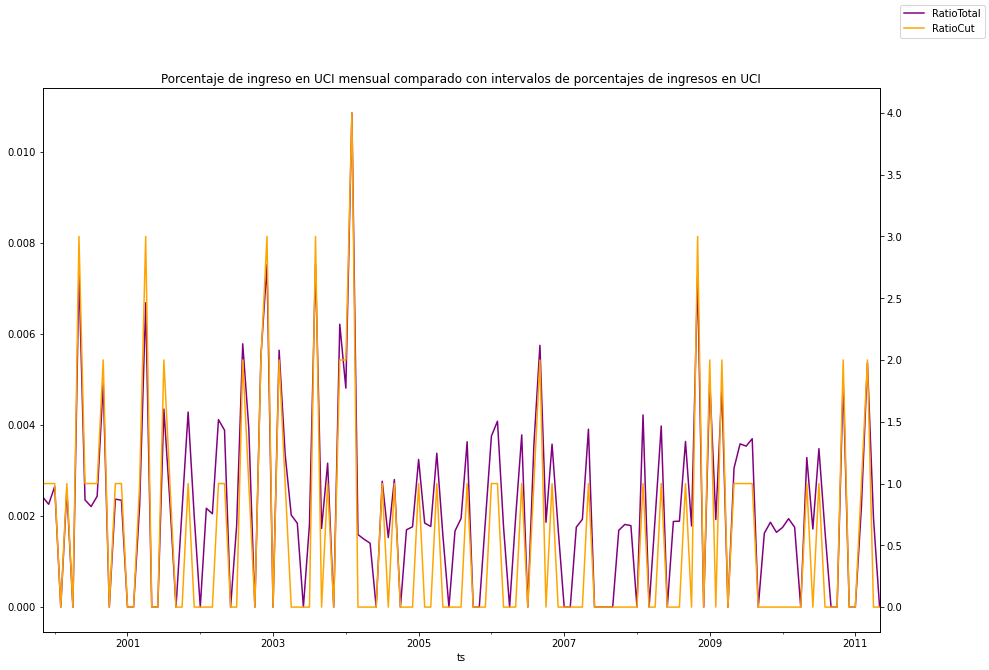

In [12]:
# Represento Ratio e intervalos de Ratio en la misma gráfica. 
df_Ratio = df_hospital.reset_index()
ax = df_Ratio.plot(x = 'ts', y = "RatioTotal", legend = False, color= 'purple', figsize=(15,10))
ax2 = ax.twinx()
df_Ratio.plot(x = 'ts', y = "RatioCut", ax = ax2, legend = False, color = "orange")
ax.figure.legend()
plt.title('Porcentaje de ingreso en UCI mensual comparado con intervalos de porcentajes de ingresos en UCI')
plt.show();

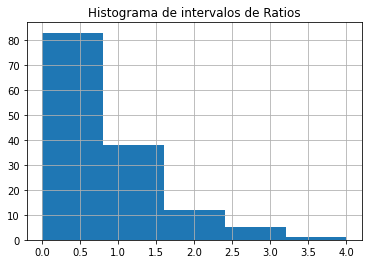

In [13]:
# Creo histograma con 5 contenedores (RatioCut), para entender comportamiento de la distribución. 
df_hospital.RatioCut.hist(bins = 5)
plt.title('Histograma de intervalos de Ratios')
plt.show();

Con anterior gráfico, podemos observar que el acumulado de todos los ratios de ingresos en UCI del histórico de datos que tenemos, no sigue una distribución uniforme

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


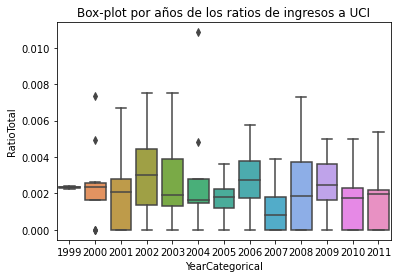

In [14]:
# Creo gráfico box-plot para estudiar datos atípico
df_hospital['YearCategorical'] = df_hospital.year.astype(str)
sns.boxplot(df_hospital['YearCategorical'], df_hospital['RatioTotal']).set_title('Box-plot por años de los ratios de ingresos a UCI');

El enfermero fué arrestado el nueve de febrero de 2004. Y el día 6 de febrero, ya no trabajó.
Se observan datos atípico en el año 2004, de los cuales coincidio que Ben trabajó enero y hasta el día 5 de febrero. Los datos de febrero que tenemos son de todo el mes.
También podemos observar datos atípicos en el año 2000, en esa época aún no trabajaba Ben.

In [15]:
# Voy a observar los datos del 2003, cuando empezó a trabajar Ben (diciembre)
df_hospital.loc[df_hospital['year'] == 2003].sort_values('RatioTotal', ascending = False).iloc[0:3]

,Cardio,Resp,Hypo,Adm,year,month,date,RatioCardio,RatioResp,RatioHypo,RatioTotal,RatioCut,YearCategorical
ts,,,,,,,,,,,,,
2003-08-01,3,1,0,532,2003,8,2003-08-01,0.005639,0.001880,0.0,0.007519,3,2003
2003-12-01,0,4,0,644,2003,12,2003-12-01,0.000000,0.006211,0.0,0.006211,2,2003
2003-02-01,2,1,0,532,2003,2,2003-02-01,0.003759,0.001880,0.0,0.005639,2,2003


Podemos ver, que el mes con más ratio, no trabajaba Ben en el hospital. Sin embargo el segundo mes con más ratio, sí que estaba Ben trabajando.

In [16]:
# Analizo los datos atípicos encontrados en el 2004
df_hospital.loc[(df_hospital['RatioTotal'] > 0.004) & (df_hospital['year'] == 2004)]

,Cardio,Resp,Hypo,Adm,year,month,date,RatioCardio,RatioResp,RatioHypo,RatioTotal,RatioCut,YearCategorical
ts,,,,,,,,,,,,,
2004-01-01,1,2,0,624,2004,1,2004-01-01,0.001603,0.003205,0.000000,0.004808,2,2004
2004-02-01,3,2,1,553,2004,2,2004-02-01,0.005425,0.003617,0.001808,0.010850,4,2004


En este caso, efectivamente Ben estaba de servicio, pero el mes de febrero trabajo 5 días. No tengo información si alguno de los ingresos contabilizados ocurrieron después del 5 de febrero. 
Con estos datos no veo claro que el incremento de casos derivados sean consecuencia de la persona arrestada.


Como los meses que le imputan son Diciembre2003, Enero2004 y Febrero2004
Quiero calcular la media móvil de tres meses y graficarlo a ver si se puede extraer alguna informacion

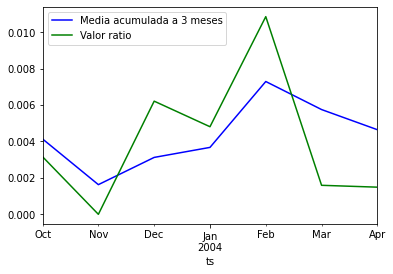

In [17]:
# Calculo media móvil
df_hospital['ThreeMonthAVG'] = df_hospital['RatioTotal'].rolling(3).mean().fillna(0)
df_hospital['2003-10-1':'2004-4-1'].ThreeMonthAVG.plot(color='blue', label='Media acumulada a 3 meses')
df_hospital['2003-10-1':'2004-4-1'].RatioTotal.plot(color='green', label='Valor ratio ')
plt.legend()
plt.show();

La media acumulada, ya nos estaba indicando que la tendencia para los meses en los que trabajaba Ben era ascendente. He elegido 3 meses de media móvil, ya que son los meses que estuvo trabajando Ben.

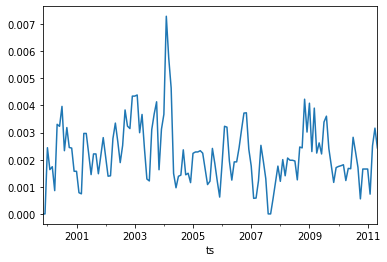

In [18]:
df_hospital['ThreeMonthAVG'].plot()

Podemos observar en el gráfico de las medias móviles a 3 meses, que se aprecia algo inusual a finales de 2003 y principio de 2004. Aún no podemos encontrar una relación entre Ben y ese pico en 2004.

Vamos a verificar si se cumple la distribución uniforme año tras año

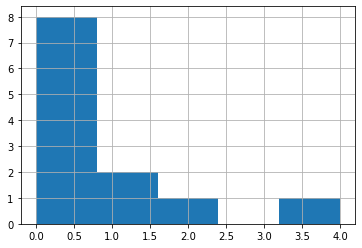

In [19]:
df_hospital.loc[df_hospital['year'] == 2004]['RatioCut'].hist(bins=5)

Voy a pasar lo valores a intervalos

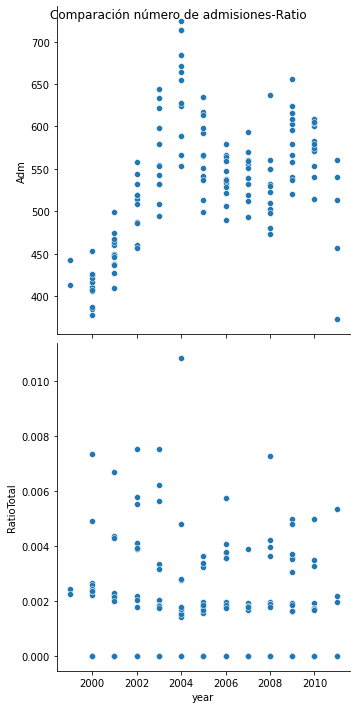

In [20]:
g = sns.pairplot(df_hospital, x_vars=['year'], y_vars=['Adm', 'RatioTotal'], height=5, aspect=1)
g.fig.suptitle('Comparación número de admisiones-Ratio');

En este último gráfico podemos ver como el número de admisiones aumenta desde el 2000 hasta el 2004, último año en que trabaja Ben. Este hecho ayuda a que se presentes más problemas derivados a las UCIS, ya que el aumento de admisiones también afecta al funcionamiento normal del hospital. El aumento del ratio de ingresados en UCI parece tener relación con el número de admisiones, lógicamente. El número de admisiones no está relacionado con las personas que puedan trabajar en un hospital.

In [21]:
# Creo dataframe con los datos de cuando no estuvo Ben
df_no_ben = df_hospital.loc[(df_hospital['date'] > '2004-02-01') | (df_hospital['date'] < '2003-12-1')]

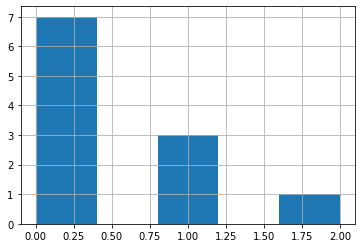

In [22]:
# Compruebo distribución
df_no_ben.loc[df_no_ben['month'] == 1]['RatioCut'].hist(bins=5);

In [23]:
# Creo dataframe con los datos cuando sí estuvo Ben
df_ben = df_hospital.loc[(df_hospital['date'] <= '2004-02-01') & (df_hospital['date'] >= '2003-12-1')]

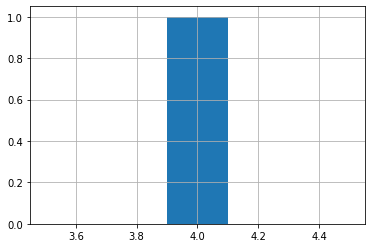

In [24]:
df_ben.loc[df_ben['month'] == 2]['RatioCut'].hist(bins=5);

Observando los histogramas no se ve distribución uniforme ni con Ben ni sin Ben en el hospital

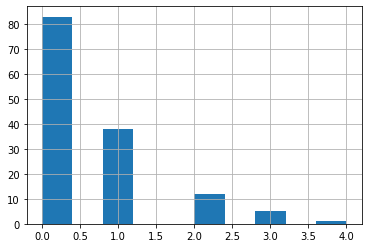

In [25]:
# Creo histograma con valores de intervalos de RatioTotal(RatioCut)
df_hospital.RatioCut.hist()

Los datos analizados se asemjan a una distribución exponencial. Debemos analizar las probabilidades no en su totalidad, si no como las diferentes probabilidades que existen de que ocurra una situación (RatioCut) 0,1,2,3 o 4 durante los datos registrados.  Asumiendo que las catergorías 0, 1, 2, 3 y 4 de RatioCut tienen las mismas probabilidades de ocurrir. Utilizaré prueba chi cuadrado para comparar las distribuciones con una distribución uniforme.

------------------------------ AHORA CALCULO CORRECTAMENTE CON LAS FRECUENCIAS EL TEST CHI CUADRADO --------------------------------

Poner estas notas, sobre los numeros de muestras, en la actividad:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html#r81ecfb019d82-3

A tener en cuenta la siguiente nota de la función 'chisquare':

"This test is invalid when the observed or expected frequencies in each category are too small. A typical rule is that all of the observed and expected frequencies should be at least 5. According to [3], the total number of samples is recommended to be greater than 13, otherwise exact tests (such as Barnard’s Exact test) should be used because they do not overreject."

En nuestro caso las muestras son 11, ya que 1999 y 2011 no contienen información de los 12 meses.

In [26]:
chiTable = pd.crosstab(df_hospital.year, df_hospital.RatioCut, margins=True)
chiTable

RatioCut,0,1,2,3,4,All
year,,,,,,
1999,0,2,0,0,0,2
2000,3,7,1,1,0,12
2001,7,3,1,1,0,12
2002,6,3,2,1,0,12
2003,7,2,2,1,0,12
2004,8,2,1,0,1,12
2005,9,3,0,0,0,12
2006,6,5,1,0,0,12
2007,11,1,0,0,0,12


In [27]:
chisquare(chiTable.iloc[13])

Power_divergenceResult(statistic=322.51798561151077, pvalue=1.4381109875495137e-67)

El totalizado de los datos dependiendo de RadioCut, no presenta uniformidad

In [28]:
# Me quedo solo con la información que tiene 12 meses
chiTable2 = pd.crosstab(df_hospital['2000-1-1':'2010-12-1'].year, df_hospital['2000-1-1':'2010-12-1'].RatioCut)
chiTable2

RatioCut,0,1,2,3,4
year,,,,,
2000,3,7,1,1,0
2001,7,3,1,1,0
2002,6,3,2,1,0
2003,7,2,2,1,0
2004,8,2,1,0,1
2005,9,3,0,0,0
2006,6,5,1,0,0
2007,11,1,0,0,0
2008,8,3,0,1,0


Parece que las probabilidades de que haya casos tipo 0, 1, 2, 3 y 4 pueden seguir una distribución uniforme

In [29]:
#Probando columnas, parece que son uniformes
p_value_RatioCut=[]
for _ in chiTable2.columns:
  chi=chisquare(chiTable2[_]).pvalue
  p_value_RatioCut.append(chi)


In [30]:
p_value_RatioCut

[0.8089231801100619,
 0.5621674160967541,
 0.8152632445237722,
 0.8152632445237724,
 0.44049328506521224]

Vemos como todos los p-value obtenidos de todos los tipos de Ratio(0-4), entre el año 2000 y 2010 son mayores de 0.05. Si tomo un nivel de confianza del 95% puedo afirmar que probabilidades de tener una tasa de ingresos baja, medio-baja, medio, medio-alta o alta, se pueden apróximar a una distribución uniforme según los resultados obtenidos en este último paso. 
Por lo tanto, uno vez analizados estos datos en los que se encuentran presentes aquellos meses en los que estuvo trabajando Ben, no presentan ninguna variación reseñable su presencia en los datos.

In [31]:
# Probando años
chisquare(chiTable2.iloc[5])
# Aquí ya aparecen veces sin uniformidad

Power_divergenceResult(statistic=25.499999999999993, pvalue=3.990690561894318e-05)

Esta última prueba no es fiable, ya que elnúmero de muestras es mucho menor de 13 (5). Si la realizamos podemos encontrarnos distribuciones tanto uniformes como no uniformes.

In [32]:
# Ahora quiero probar si los meses son uniformes
chiTableMonth = pd.crosstab(df_hospital.month, df_hospital.RatioCut)

In [33]:
#Probando columnas, parece que son uniformes
p_value_RatioCut2=[]
for _ in chiTable2.columns:
  chi_2=chisquare(chiTableMonth[_]).pvalue
  p_value_RatioCut2.append(chi_2)

In [34]:
p_value_RatioCut2

[0.9643289490548617,
 0.9597528213183678,
 0.7133038296300321,
 0.7990835013154438,
 0.4432632784264651]

Repitiendo la prueba anterior, ahora realizando una tabla cruzada con los meses, obtenemos los mismos resultdos que antes, describen una distribución uniforme.

## Comienzo a aplicar modelos

In [35]:
# Estudio los datos despúes de Ben, casi un año después de su arresto y antes de Ben
df_post_Ben = df_hospital.query('year > 2004')
df_hasta_Ben = df_hospital.query('year < 2004')

Comprobar estacionalidad
Descomponer en tres efectos
*1.-Tendencia
*2.-Estacional
*3.-Resiual

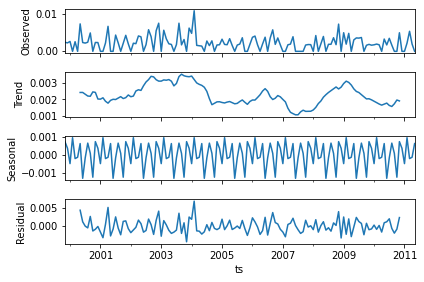

In [36]:
# Utilizo descomposición aditiva, ya que la multiplicativa me puede generar errores al tener Ratio=0
s_dec_additive = seasonal_decompose(df_hospital.RatioTotal, model = "additive")
s_dec_additive.plot()
plt.show()

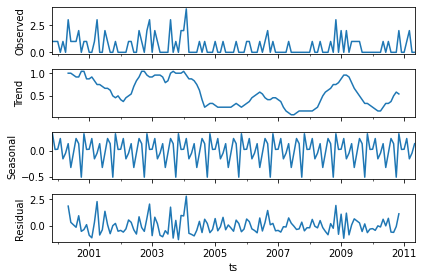

In [37]:
# Repito operación ahora con RatioCut, para una mejor visualización del gráfico
s_dec_additive = seasonal_decompose(df_hospital.RatioCut, model = "additive")
s_dec_additive.plot()
plt.show()

Con este último gráfico se ve cláramente la estacionalidad de nuestros datos. Sin embargo no se observa que los valores varien alrededor de un valor medio determinado. Debo tener en cuanta estas dos observaciones en mis modelos. También se ve como la tendencia es tanto ascendente com descendente sin patrón aparente.

Suavizado de parámetros. Utilizo filtro Heidrich_Prescott para una mejor comprensión de la tendencia de los datos a lo largo de los años. Al tratarse de datos con una periodicidad mensual, ajusto el parámetro lambda con el valor 129600 indicado en la documentación de la función

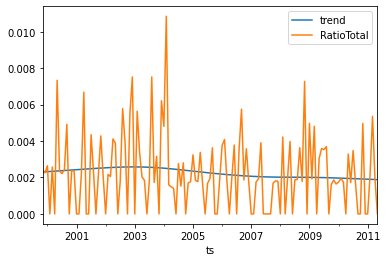

In [38]:
hosp_cycle, hosp_trend = hpfilter(df_hospital['RatioTotal'], lamb=129600)
df_hospital['trend'] = hosp_trend
df_hospital[['trend', 'RatioTotal']].plot();

En este gráfico podemos ver una clara tendencia positiva desde el año 2000 hasta apróximadamente el año 2004, lo que indica que el número de personas ingresadas a la UCI ya presentaba un patrón ascedente antes de la llegada de Ben.

Autocorrelación ACF

Procedo al studio de los factores de correlación, intentado extraer información sobre las relaciones de las observaciones con sus semejantes en el pasado, para ello utilizaré la función de autocorrelación utilizando los las anteriores 40 (lags) observaciones, valor más que suficiente para el propósito de este estudio. 

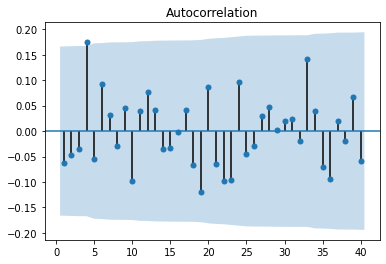

In [39]:
sgt.plot_acf(df_hospital.RatioTotal, lags=40, zero=False)
plt.show()

El cuarto retraso tiene significancia en los valores de RatioTotal. No puedo extraer mucha información con estas condiciones.

Realizo la misma operación con los datos hasta que dejó de trabajar Ben.

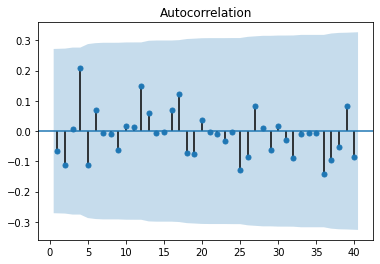

In [40]:
data_till_Ben = df_hospital.loc[(df_hospital['date'] < '2004-03-01')]
sgt.plot_acf(data_till_Ben.RatioTotal, lags=40, zero=False)
plt.show()

No se observa nada reseñable

Autocorrelación parcial PACF.

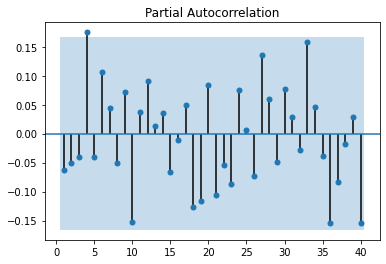

In [41]:
sgt.plot_pacf(df_hospital.RatioTotal, lags=40, zero=False, method=('ols')) # Mínimos cuadrados ordinarios
plt.show()

de nuevo, el cuarto retraso tiene significancia

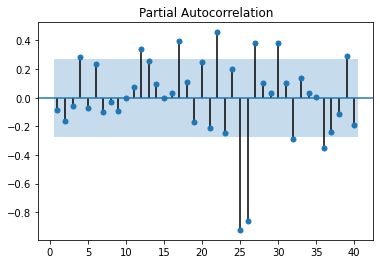

In [42]:
sgt.plot_pacf(data_till_Ben.RatioTotal, lags=40, zero=False, method=('ols')) # Mínimos cuadrados ordinarios
plt.show()

Ahora si podemos ver mayor retrasos con autocorrelación parcial.

In [43]:
# pivot tabla
df_hosp_pivot_year = df_hospital.pivot(index='year', columns='month', values='RatioCut')
df_hosp_pivot_year.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2000,1.0,0.0,1.0,0.0,3.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0
2001,0.0,0.0,1.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
2002,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,3.0
2003,0.0,2.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0


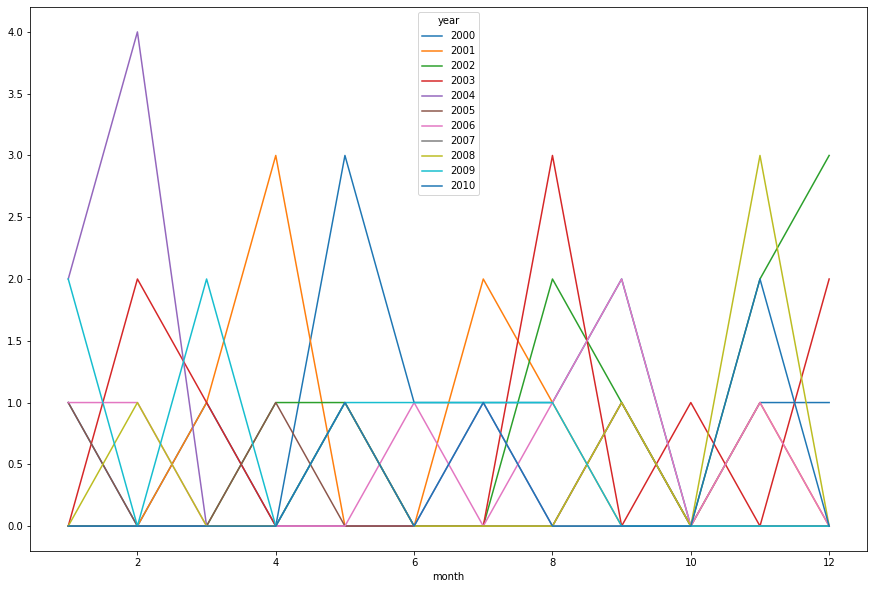

In [44]:
df_hosp_pivot_year.iloc[1:12].T.plot(figsize=(15,10))

Con este último gráfico no extraigo información útil

Voy a realizar un modelo ARMA, ya que se trata de datos estacionales

In [45]:
#Datos para entrenar, cuando no esta Ben.

In [46]:
df_post_Ben.shape[0],df_hasta_Ben.shape[0]

(77, 50)

In [47]:
## Relación 65-35 %, entrenamiento-test

Esta relación es correcta para los propósitos de este estudio, además consigo que los datos en los que coinciden las fechas con el tiempo de que estuvo Ben trabajando, no aparezcan en el dataset de entrenamiento, pudiendo compararlo posteriormente con las predicciones obtenidas. Podríamos decir que vamos a entrenar el modelo con datos teorícamente normales, para poder compararlos con datos iniciales en los que dicen que existían anomalías.

LLR Test. Programo función para calcular el "Likelihood-ratio test
" y así poder comparar entre los modelos que vaya obteniendo.

In [48]:
# Función para calcular la razón de similitud entre dos modelos, siendo el primer modelo de menor grados de libertad
def LLR_test(mod_1, mod_2, DF = 1):
    L1 = mod_1.llf
    L2 = mod_2.llf
    LR = (2*(L2-L1))    
    p = chi2.sf(LR, DF).round(3)
    return p

In [49]:
df_train = pd.DataFrame(df_post_Ben['RatioTotal'])
df_train.head()

,RatioTotal
ts,
2005-01-01,0.003241
2005-02-01,0.001845
2005-03-01,0.001770
2005-04-01,0.003378
2005-05-01,0.001575


In [50]:
df_test = pd.DataFrame(df_hasta_Ben['RatioTotal'])
df_test.head()

,RatioTotal
ts,
1999-11-01,0.002421
1999-12-01,0.002257
2000-01-01,0.002646
2000-02-01,0.000000
2000-03-01,0.002577


Creando Returns. Ya que mis valores de RatioTotal oscilan entre [0,inf), lo cual no presenta estacionalidad. Para asegurarme de tener estacionalidad, calculo los valores de las variaciones porcentuales entre cada obsedrvación y su observación anterior. De esta manera consigo que mi nueva variable alterne entre valores alrededor de 0, consiguiendo así estacionalidad.

In [51]:
# El cambio de una observación por la anterior en tanto por ciento
df_train['returns'] = df_train.RatioTotal.pct_change(1)*100
df_train

,RatioTotal,returns
ts,,
2005-01-01,0.003241,NaN
2005-02-01,0.001845,-43.081181
2005-03-01,0.001770,-4.070796
2005-04-01,0.003378,90.878378
2005-05-01,0.001575,-53.385827
...,...,...
2011-01-01,0.000000,NaN
2011-02-01,0.002188,inf
2011-03-01,0.005357,144.821429


In [52]:
# Creo modelo ARMA

model_retRatio_ar_1_ma_1 = ARMA(df_train.RatioTotal[0:], order=(1,1))
results_retRatio_ar_1_ma_1 = model_retRatio_ar_1_ma_1.fit()
results_retRatio_ar_1_ma_1.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:             RatioTotal   No. Observations:                   77
Model:                     ARMA(1, 1)   Log Likelihood                 382.458
Method:                       css-mle   S.D. of innovations              0.002
Date:                Wed, 16 Feb 2022   AIC                           -756.915
Time:                        14:21:57   BIC                           -747.540
Sample:                    01-01-2005   HQIC                          -753.165
                         - 05-01-2011                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0020      0.000     11.940      0.000       0.002       0.002
ar.L1.RatioTotal     0.1608      0.701      0.229      0.819      -1.213       1.534
ma.L1.RatioTotal    -0.2743      0.678     -0.405      0.687      -1.603       1.054
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            6.2178           +0.0000j            6.2178            0.0000
MA.1            3.6452           +0.0000j            3.6452            0.0000
-----------------------------------------------------------------------------
"""

Tengo problemos al ejecutar el modelo, ya que al tener valores=0 en los ratios, al cacular los retornos, obtengo valores infinitos y NaNs.
Voy a sumar 1 a todas las observaciones para tratar de solucionar este inconveniendte.
Es como si subo mi BIAS

In [53]:
df_train['RatioTotal'] = df_train['RatioTotal'] + 1
df_test['RatioTotal'] = df_test['RatioTotal'] + 1
df_train['returns'] = df_train.RatioTotal.pct_change(1)*100
df_train

,RatioTotal,returns
ts,,
2005-01-01,1.003241,NaN
2005-02-01,1.001845,-0.139196
2005-03-01,1.001770,-0.007497
2005-04-01,1.003378,0.160563
2005-05-01,1.001575,-0.179750
...,...,...
2011-01-01,1.000000,0.000000
2011-02-01,1.002188,0.218818
2011-03-01,1.005357,0.316204


In [54]:
model_retRatio_ar_1_ma_1 = ARMA(df_train.returns[1:], order=(1,1))
results_retRatio_ar_1_ma_1 = model_retRatio_ar_1_ma_1.fit()
results_retRatio_ar_1_ma_1.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                   76
Model:                     ARMA(1, 1)   Log Likelihood                  24.806
Method:                       css-mle   S.D. of innovations              0.169
Date:                Wed, 16 Feb 2022   AIC                            -41.612
Time:                        14:21:57   BIC                            -32.289
Sample:                    02-01-2005   HQIC                           -37.886
                         - 05-01-2011                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.508      0.613      -0.001       0.002
ar.L1.returns    -0.0956      0.116     -0.828      0.410      -0.322       0.131
ma.L1.returns    -1.0000      0.042    -23.651      0.000      -1.083      -0.917
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -10.4573           +0.0000j           10.4573            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

Ahora el modelo ya tiene al menos un coeficiente significante. Calculamos si el modelo es mejor predictor comparándolo con un modelo AR y con un modelo MA.

In [55]:
model_ret_ar_1 = ARMA(df_train.returns[1:], order = (1,0))
model_ret_ma_1 = ARMA(df_train.returns[1:], order = (0,1))
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ma_1 = model_ret_ma_1.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [56]:
print("\nARMA vs AR ", LLR_test(results_ret_ar_1, results_retRatio_ar_1_ma_1))
print("\nARMA vs MA ", LLR_test(results_ret_ma_1, results_retRatio_ar_1_ma_1))


ARMA vs AR  0.0

ARMA vs MA  0.41


ARMA es mejor que modelo AR, pero con estos parámetros, no es mejor que un modelo de medias móviles.

--------------------SEGUIR DESDE AQUI ---------------------------

ACF y PACF para los retornos

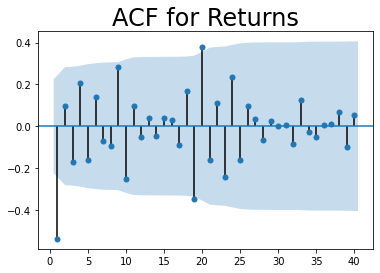

In [57]:
# ACF retornos
sgt.plot_acf(df_train.returns[1:], zero = False, lags = 40)
plt.title("ACF for Returns",size=24)
plt.show()

En esta ocasión encontramos tres retrasos con correlación

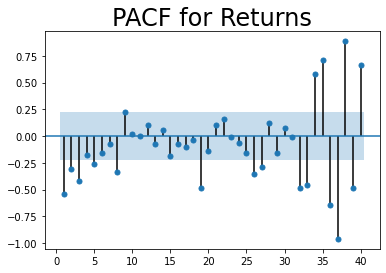

In [58]:
# PCAF retornos
sgt.plot_pacf(df_train.returns[1:], zero = False, lags = 40, method='ols')
plt.title("PACF for Returns",size=24)
plt.show()

Ahora hay 18 retornos con correlación parcial

Pruebo un nuevo modelo ahora con ARMA(3,3), para tener al menos, los 3 retrasos encotrados en el gráfico de ACF de retornos

In [59]:
model_retRatio_ar_3_ma_3 = ARMA(df_train.returns[1:], order=(3,3))
results_retRatio_ar_3_ma_3 = model_retRatio_ar_3_ma_3.fit()
results_retRatio_ar_3_ma_3.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:695: RuntimeWarning: divide by zero encountered in true_divide
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


LinAlgError: ignored

Comparo el modelo con ARMA(1,1)

Antes no me daba error este código. Compruebo que no tengo NaNs ni valores infinitos. Reinicio la máquina pero sigue fallando. En las anteriores pruebas me daba un modelo con 1 coeficiente regresor de la parte AR sin sifnificancia.

In [ ]:
LLR_test(results_retRatio_ar_1_ma_1, results_retRatio_ar_3_ma_3, DF = 4)

Tengo un coeficiente no significativo, pruebo un modelo menos complejo, en vez 3 coeficientes para la parte AR, pongo 2 para intentar eliminar el coeficiente menos significante

In [60]:
model_retRatio_ar_2_ma_3 = ARMA(df_train.returns[1:], order=(2,3))
results_retRatio_ar_2_ma_3 = model_retRatio_ar_2_ma_3.fit()
results_retRatio_ar_2_ma_3.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                   76
Model:                     ARMA(2, 3)   Log Likelihood                  28.064
Method:                       css-mle   S.D. of innovations              0.159
Date:                Wed, 16 Feb 2022   AIC                            -42.127
Time:                        14:22:21   BIC                            -25.812
Sample:                    02-01-2005   HQIC                           -35.607
                         - 05-01-2011                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.001      0.329      0.743      -0.001       0.002
ar.L1.returns    -1.6124      0.083    -19.379      0.000      -1.775      -1.449
ar.L2.returns    -0.8028      0.080    -10.023      0.000      -0.960      -0.646
ma.L1.returns     0.7327      0.076      9.618      0.000       0.583       0.882
ma.L2.returns    -0.7328      0.073    -10.086      0.000      -0.875      -0.590
ma.L3.returns    -0.9999      0.082    -12.240      0.000      -1.160      -0.840
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0043           -0.4869j            1.1161           -0.4281
AR.2           -1.0043           +0.4869j            1.1161            0.4281
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -0.8664           -0.4994j            1.0000           -0.4168
MA.3           -0.8664           +0.4994j            1.0000            0.4168
-----------------------------------------------------------------------------
"""

In [61]:
# DF= GradosLibertad modelo 2 - GradosLibertad modelo 1 = (2+3)-(1+1)
# Siendo cada témino entre paréntisis del modelo 2 >= que su correspondiente 
# en el modelo 1 (anidados)
LLR_test(results_retRatio_ar_1_ma_1, results_retRatio_ar_2_ma_3, DF = 3)

0.089

Este sale que es peor, pero tenemos que recordar que nuestro modelo ARMA(1,1) tenía un coeficiente no significativo. Voy a testear el modelo ARMA(0,1) para comparar el resultado con este anterior ARMA(2,3)


Pruebo con (0,1)


In [62]:
model_retRatio_ar_0_ma_1 = ARMA(df_train.returns[1:], order=(0,1))
results_retRatio_ar_0_ma_1 = model_retRatio_ar_0_ma_1.fit()
results_retRatio_ar_0_ma_1.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                returns   No. Observations:                   76
Model:                     ARMA(0, 1)   Log Likelihood                  24.466
Method:                       css-mle   S.D. of innovations              0.170
Date:                Wed, 16 Feb 2022   AIC                            -42.932
Time:                        14:22:21   BIC                            -35.940
Sample:                    02-01-2005   HQIC                           -40.138
                         - 05-01-2011                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.001      0.429      0.669      -0.001       0.002
ma.L1.returns    -1.0000      0.040    -25.055      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [63]:
LLR_test(results_retRatio_ar_0_ma_1, results_retRatio_ar_2_ma_3, DF = 4)

0.126

Aqui me sale que es mejor el 0,1 que el 1,1

Me quedo tambien con el modelo 2,3

Miro tabla ARMA y comparo Log Likelihood y me quedo con el valor mayor.
AIC: criterio de información, me quedo con el más bajo.

Analizo residuos

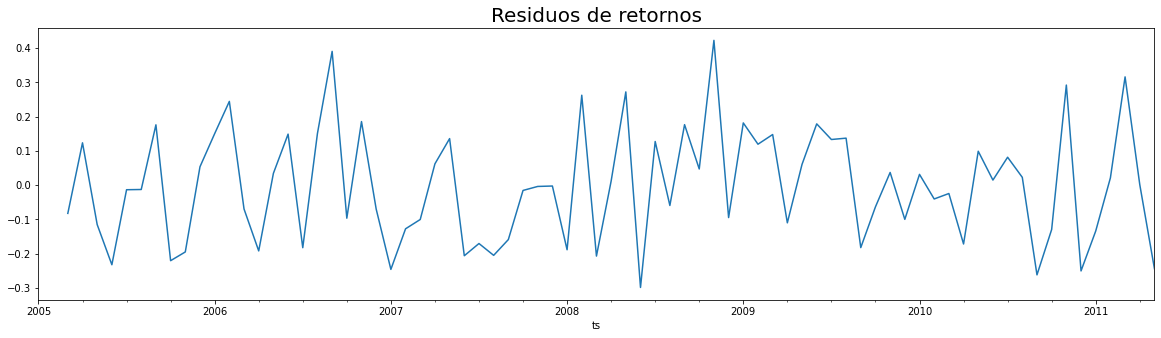

In [64]:
df_train['results_retRatio_ar_2_ma_3'] = results_retRatio_ar_2_ma_3.resid[1:]
df_train.results_retRatio_ar_2_ma_3.plot(figsize=(20,5))
plt.title("Residuos de retornos", size=20)
plt.show();

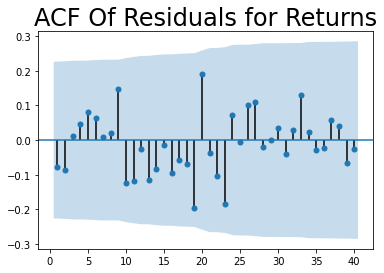

In [65]:
# Compruebo ACF sobre el modelo
sgt.plot_acf(df_train.results_retRatio_ar_2_ma_3[2:], zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=24)
plt.show()

Como vemos en el gráfico, ya no tenemos autocorrelación, así que el modelo parece suficiente

Por todo lo anterior, me quedo con el modelo ARMA(2,3) y variable returns
, por tener todos los coeficientes significancia y ademas poseer mas Log Likehood.

In [66]:
# Calculo retornos para el dataframe de test
df_test['returns'] = df_test.RatioTotal.pct_change(1)*100

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


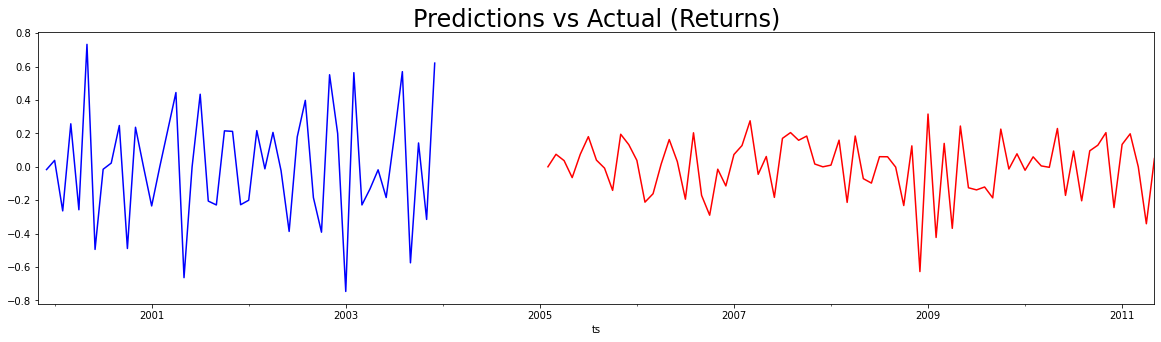

In [67]:
model_ret_arma = ARMA(df_train.returns[1:], order=(2,3))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict() 

df_pred_arma.plot(figsize = (20,5), color = "red")   
df_test.returns.plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

Ahora pruebo las predicciones sobre los datos Test hasta fin de trabajo de Ben

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


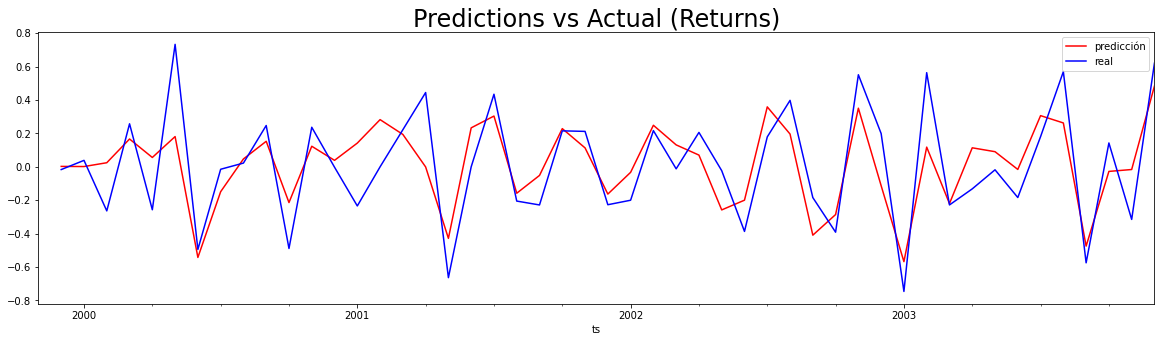

In [68]:
# df_test = datos desde inicio hasta fin de Ben
model_retTest_arma = ARMA(df_test.returns[1:], order=(2,3))
results_retTest_arma = model_retTest_arma.fit()

df_predTest_arma = results_retTest_arma.predict() 

df_predTest_arma.plot(figsize = (20,5), color = "red", label='predicción')   
df_test.returns.plot(color = "blue", label='real')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show();

Preparo los dataframe para utilizar predicción en todos los datos

In [69]:
df_test_total = pd.DataFrame(df_hospital['RatioTotal'])
df_test_total['RatioTotal'] = df_test_total['RatioTotal'] + 1
df_test_total['returns'] = df_test_total.RatioTotal.pct_change(1)*100
df_test_total

,RatioTotal,returns
ts,,
1999-11-01,1.002421,NaN
1999-12-01,1.002257,-0.016358
2000-01-01,1.002646,0.038729
2000-02-01,1.000000,-0.263852
2000-03-01,1.002577,0.257732
...,...,...
2011-01-01,1.000000,0.000000
2011-02-01,1.002188,0.218818
2011-03-01,1.005357,0.316204


Compruebo modelo con todos los datos

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


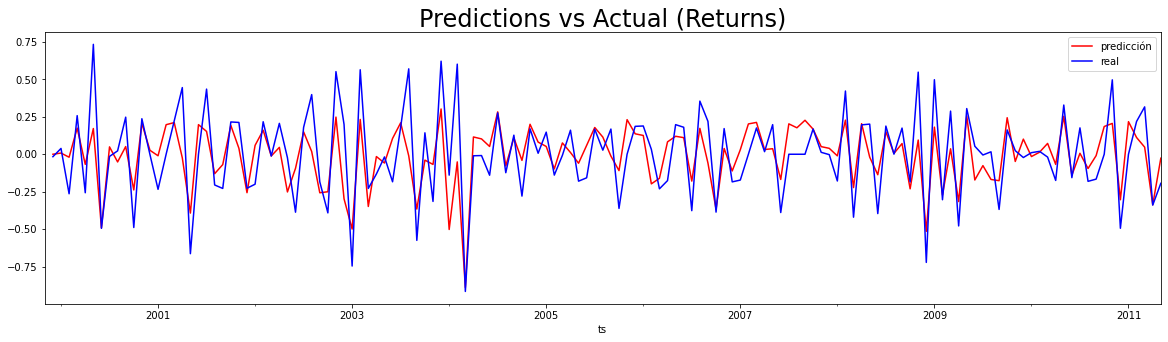

In [70]:
# Todos las observaciones disponibles
model_retTestTotal_arma = ARMA(df_test_total.returns[1:], order=(2,3))
results_retTestTotal_arma = model_retTestTotal_arma.fit()

df_predTestTotal_arma = results_retTestTotal_arma.predict() 

df_predTestTotal_arma.plot(figsize = (20,5), color = "red", label='predicción')   
df_test_total.returns.plot(color = "blue", label='real')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show()

Ahora me centro en los datos obtenidos para Ben, desde 2003 hasta final de 2004

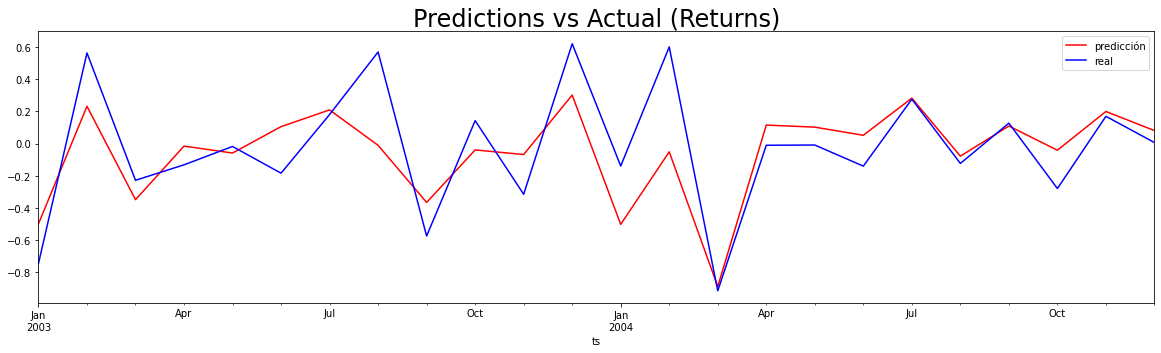

In [71]:
df_predTestTotal_arma['2003-1-1':'2004-12-1'].plot(figsize = (20,5), color = "red", label='predicción')   
df_test_total['2003-1-1':'2004-12-1'].returns.plot(color = "blue", label='real')
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.legend()
plt.show();

Los meses de diciembre 2003 y enero, febrero de 2004, podemos ver como la predicción realizada a partir de los datos posteriores a Ben, acierta tanto en el sentido de la tendencian como proporcionalmente. Pasamos a verlo numñericamente.

In [72]:
# Calculo errores enero 2004 - diciembre 2003
variacion_error1 = (df_test_total.returns['2004-1-1'] - df_test_total.returns['2003-12-1']) - (df_predTestTotal_arma['2004-1-1'] - df_predTestTotal_arma['2003-12-1'])
variacion_error2 = (df_test_total.returns['2004-2-1'] - df_test_total.returns['2004-1-1']) - (df_predTestTotal_arma['2004-2-1'] - df_predTestTotal_arma['2004-1-1'])
variacion_error3 = (df_test_total.returns['2004-3-1'] - df_test_total.returns['2004-2-1']) - (df_predTestTotal_arma['2004-3-1'] - df_predTestTotal_arma['2004-2-1'])

print('Varianción entre predicción y real entre 2004-1-1 y 2003-12-1 es: {:.2f}'.format(variacion_error1))
print('Varianción entre predicción y real entre 2004-2-1 y 2004-1-1 es: {:.2f}'.format(variacion_error2))
print('Varianción entre predicción y real entre 2004-3-1 y 2004-2-1 es: {:.2f}'.format(variacion_error3))

Varianción entre predicción y real entre 2004-1-1 y 2003-12-1 es: 0.04
Varianción entre predicción y real entre 2004-2-1 y 2004-1-1 es: 0.29
Varianción entre predicción y real entre 2004-3-1 y 2004-2-1 es: -0.68


Teniendo en cuenta que en la gráfica mostrada anteriormente, el punto más bajo es debido a la existencia de valores atípico muy extremos, el modelo a sabido comportarse bastante bien para poder predecir ese instante, sin embargo el mayor error de variabilidad los vemos en la diferencia entre marzo y febrero de 2004. El resto de errores podemos ver que son bastante aceptables, sobre todo si nos fijamos en la diferencia de 0.09 que encontramos entre 2004-1-1 y 2003-12-1. 
Por todo lo comentado, el modelo predictivo se ajusta bastante bien a los valores de las observaciones.

# OTRO MODEO

Gradient booted trees. FaceBook prophet

Dejo datos originales y lo almaceno en nuevo DataFrame

In [162]:
df_train_fbp = df_train['RatioTotal'] - 1
df_train_fbp = pd.DataFrame(df_train_fbp)
df_train_fbp['returns'] = df_test_total.RatioTotal.pct_change(1)*100


In [163]:
df_test_fbp = df_test['RatioTotal'] - 1
df_test_fbp = pd.DataFrame(df_test_fbp)
df_test_fbp['returns'] = df_test_total.RatioTotal.pct_change(1)*100


In [164]:
from fbprophet import Prophet

In [165]:
# Adecúo datos a requerimientos de la función FacebookProphet

df_train_fbp.reset_index(inplace=True)
df_test_fbp.reset_index(inplace=True)

df_train_fbp.drop('RatioTotal', axis=1, inplace=True)
df_test_fbp.drop('RatioTotal', axis=1, inplace=True)

df_train_fbp.columns = ['ds', 'y']
df_test_fbp.columns = ['ds', 'y']

df_test_fbp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      50 non-null     datetime64[ns]
 1   y       49 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 928.0 bytes


In [166]:
# Entreno modelo
model_fbp = Prophet()
model_fbp.fit(df_train_fbp)
df_past = model_fbp.predict(df_test_fbp)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [167]:
# Compruebo observaciones de entrenamiento y de test
df_train.shape[0], df_test.shape[0]

(77, 50)

In [85]:
df_test_fbp.set_index('ds', inplace=True)

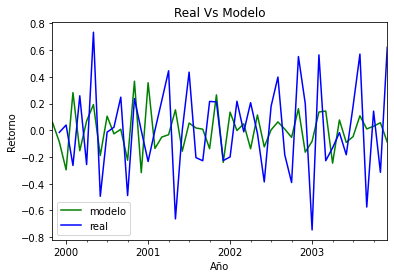

In [171]:
# Grafico modelo versus datos
#df_test_fbp.set_index('ds', inplace=True)
df_past.plot(x = 'ds', y='yhat', label = 'modelo', color= 'green')
df_test_fbp.y.plot(color='blue', label = 'real')
plt.xlabel('Año')
plt.ylabel('Retorno')
plt.legend()
plt.title('Real Vs Modelo')
plt.show()

In [182]:
# Gracias a Elisa Cabana por el código https://aprendeconeli.com/curso-series-temporales/

def hampel_filter_forloop(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [183]:
# Calculo filtro con distintas ventanas, utilizo número de sigmas determinado, 3

res, detected_outliersW3 = hampel_filter_forloop(df_hospital.RatioTotal, 3)
res, detected_outliersW6 = hampel_filter_forloop(df_hospital.RatioTotal, 6)
res, detected_outliersW12 = hampel_filter_forloop(df_hospital.RatioTotal, 12)

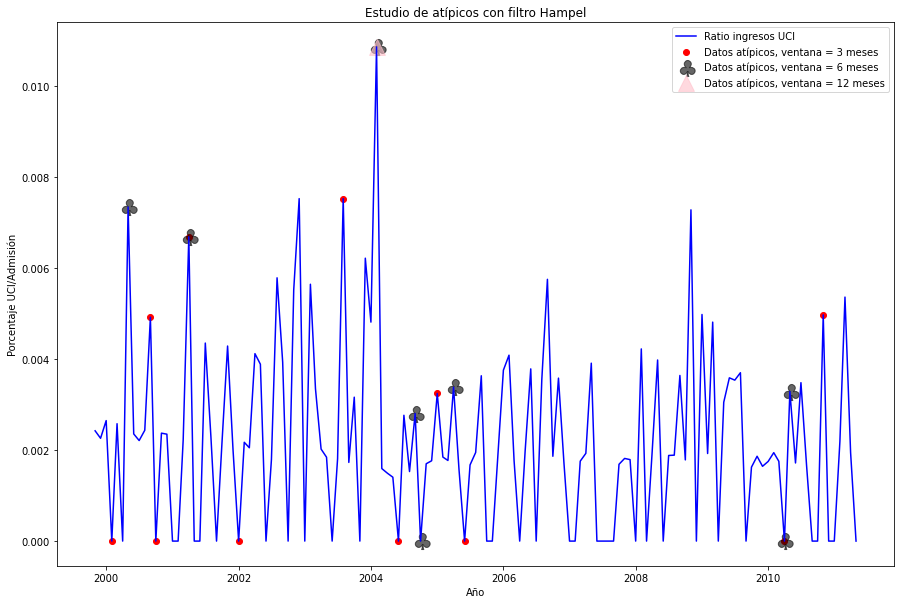

In [184]:
# Grafico datos reales con los atípicos detectados por el filtro con distintas ventanas

plt.figure(figsize=[15,10])
plt.scatter(df_hospital.iloc[detected_outliersW3].index, df_hospital.iloc[detected_outliersW3]['RatioTotal'].values
            , color='red', label='Datos atípicos, ventana = 3 meses')
plt.scatter(df_hospital.iloc[detected_outliersW6].index, df_hospital.iloc[detected_outliersW6]['RatioTotal'].values
            , color='black', label='Datos atípicos, ventana = 6 meses', alpha=0.6, marker=r'$\clubsuit$', s=300)
plt.scatter(df_hospital.iloc[detected_outliersW12].index, df_hospital.iloc[detected_outliersW12]['RatioTotal'].values
            , color='pink', label='Datos atípicos, ventana = 12 meses', alpha = 0.6, marker=r'^', s=250)
plt.plot(df_hospital.RatioTotal, color='blue', label='Ratio ingresos UCI')
plt.legend()
plt.xlabel('Año')
plt.ylabel('Porcentaje UCI/Admisión')
plt.title('Estudio de atípicos con filtro Hampel')
plt.show();

CONCLUSIONES